# IRIS RCA median week

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colrs

from descartes.patch import PolygonPatch

from shapely.ops import transform as Shapely_transform

from pyspark.sql import SparkSession
import pyspark.sql.functions as spark_functions
import pyspark.sql.types as spark_types
from pyspark.sql.functions import col, pandas_udf, PandasUDFType,udf,broadcast

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['CMU Serif Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16

In [3]:
USER = os.getlogin()
WORKING_DIR = f'/home/{USER}/data/Land_use'
DATA_DIR = f'{WORKING_DIR}/data'
METROPOLES_SHAPE = f'{DATA_DIR}/cities'
IMG_DIR = f'{WORKING_DIR}/images'

In [4]:
spark = SparkSession.builder\
    .master('spark://santiago:7077')\
    .appName('Land use - RCA median week')\
    .config('spark.network.timeout', 300)\
    .config('spark.dynamicAllocation.enabled', 'true')\
    .config('spark.shuffle.service.enabled', 'true')\
    .config('spark.dynamicAllocation.initialExecutors', 1)\
    .config('spark.dynamicAllocation.maxExecutors', 40)\
    .config('spark.dynamicAllocation.minExecutors', 0)\
    .config('spark.driver.maxResultSize', '120g')\
    .config('spark.executor.cores', 1)\
    .config('spark.executor.memory', '4g')\
    .config('spark.memory.fraction', 0.6)\
    .config('spark.cores.max', 40)\
    .config('spark.executor.memoryOverhead', '8g')\
    .config('spark.driver.memoryOverhead', '8g')\
    .getOrCreate()

spark.conf.set('spark.sql.session.timeZone', 'Europe/Paris')

2023-08-14 19:54:54,185 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-08-14 19:54:54,559 WARN spark.SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
2023-08-14 19:54:55,057 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load Data

### City mask

In [5]:
CITY_NAME = 'Lyon'
df_mask = pd.read_pickle(f'{DATA_DIR}/df_masks.pkl')
city_row = df_mask[df_mask['name'] == CITY_NAME].iloc[0]

city_shape = city_row['shape']
city_mask = city_row['mask']
city_left_x = city_row['left_x']
city_bottom_y = city_row['bottom_y']

### Median Week

In [6]:
filename = f'hdfs://santiago:9000/land_use/{CITY_NAME}/iris_traffic_maps_median_week.parquet'
sdf_traffic = spark.read.parquet(filename)
sdf_traffic.show(2)

+----+-------------------+--------+-----------+--------------------+--------------------+
|city|                app|    time|day_of_week|         traffic_map|    traffic_map_iris|
+----+-------------------+--------+-----------+--------------------+--------------------+
|Lyon|Amazon Web Services|10:30:00|     Friday|[[0.0, 0.0, 0.0, ...|[489191.25, 31947...|
|Lyon|    Apple App Store|01:30:00|     Friday|[[0.0, 0.0, 0.0, ...|[2632871.0, 41285...|
+----+-------------------+--------+-----------+--------------------+--------------------+
only showing top 2 rows



### Load IRIS to cell ratio

In [10]:
df_iris_ratio = pd.read_pickle(f'{DATA_DIR}/cell_iris_ratio/df_ratio_{CITY_NAME}.pkl')

df_iris_ratio = df_iris_ratio[['iris_index', 'iris_code', 'geometry', 'area']]
df_iris_ratio = df_iris_ratio.drop_duplicates(subset=['iris_index'])
df_iris_ratio.sort_values(by=['iris_index'], inplace=True)

iris_shapes = list(df_iris_ratio['geometry'])
iris_shapes_to_plot = [Shapely_transform(lambda x,y: (y, x), iris_shape) for iris_shape in iris_shapes]
iris_areas = list(df_iris_ratio['area'])

df_iris_ratio.head(2)

,iris_index,iris_code,geometry,area
68,0,692820201,"POLYGON ((45.77108 5.00362, 45.77110 5.00364, ...",662089.744473
294,1,692860202,"POLYGON ((45.80925 4.89968, 45.80917 4.89959, ...",323040.710326


## Plot Matrix Traffic maps vs IRIS Traffic maps

In [8]:
sdf_traffic_app_day = sdf_traffic.filter((sdf_traffic['app'] == 'Youtube') & (sdf_traffic['day_of_week'] == 'Monday'))
df_traffic_app_day = sdf_traffic_app_day.toPandas()
df_traffic_app_day.sort_values(by=['time'], inplace=True)
df_traffic_app_day.head(2)

,city,app,time,day_of_week,traffic_map,traffic_map_iris
21,Lyon,Youtube,00:00:00,Monday,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[21226900.0, 11615168.0, 5021481.0, 45058372.0..."
20,Lyon,Youtube,00:30:00,Monday,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[27800738.0, 9269139.0, 3429876.0, 37571584.0,..."


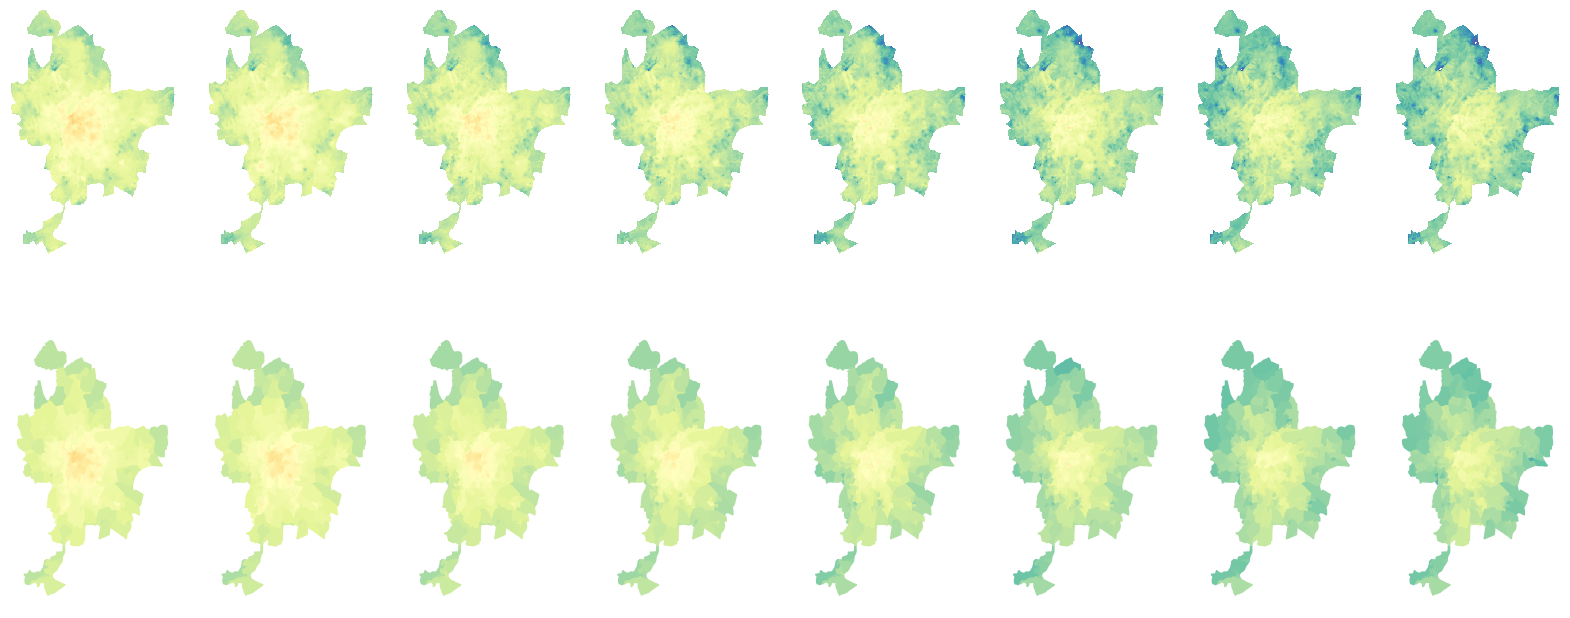

In [13]:
times = list(df_traffic_app_day['time'])
time_interval = 6
n_times = len(df_traffic_app_day)
n_maps = n_times // time_interval


my_cmap_traffic = cm.get_cmap('Spectral_r').copy()
my_cmap_traffic.set_under('w', 0)
norm_traffic = colrs.LogNorm(vmin=1e2, vmax=1e10)

fig, axs = plt.subplots(nrows=2, ncols=n_maps, figsize=(20, 8))

for i in range(n_maps):
    time = times[i*time_interval]

    row = df_traffic_app_day.iloc[i]
    traffic_map = row['traffic_map']
    iris_traffic_map = row['traffic_map_iris']

    ax = axs[0, i]
    ax.imshow(traffic_map, cmap=my_cmap_traffic, norm=norm_traffic, origin='lower', interpolation='nearest')
    ax.axis('off')

    ax = axs[1, i]
    for iris_shape, iris_traffic, iris_area in zip(iris_shapes_to_plot, iris_traffic_map, iris_areas):
        iris_traffic /= (iris_area/(100*100))
        color = colrs.to_hex(my_cmap_traffic(norm_traffic(iris_traffic)))
        patch = PolygonPatch(iris_shape, fc=color, ec=color, lw=1)
        ax.add_patch(patch)
    ax.axis('off')
    ax.autoscale(True)

plt.show()

In [59]:
iris_shape.area

1.3427756274600748e-05

In [10]:
# some_rows = sdf_traffic.take(10)
# data = []
# for row in some_rows:
#     data.append(row.asDict())

# df = pd.DataFrame(data)
# sdf_small = spark.createDataFrame(df)
# sdf_small.show(2)

## RCA

### Traffic maps and Traffic per app

In [8]:
schema_traffic_map = spark_types.ArrayType(spark_types.ArrayType(spark_types.FloatType()))

@pandas_udf(schema_traffic_map)
def total_traffic_map(traffic_maps: pd.Series)-> schema_traffic_map:
    traffic_maps = traffic_maps.apply(lambda traffic_map: np.array(list(traffic_map)))
    traffic_map = traffic_maps.sum(axis=0)

    return traffic_map.tolist()

In [9]:
schema_sum = spark_types.FloatType()

@udf(schema_sum)
def apply_sum(traffic_map) -> schema_sum:
    traffic_map = np.array(list(traffic_map))
    return float(np.sum(traffic_map))

In [10]:
sdf_traffic_time = sdf_traffic.groupBy('city', 'time','day_of_week').agg(total_traffic_map('traffic_map').alias('traffic_map'))
sdf_traffic_time = sdf_traffic_time.withColumn('traffic', apply_sum('traffic_map'))
sdf_traffic_time.show(2)

+-----+--------+-----------+--------------------+-------------+
| city|    time|day_of_week|         traffic_map|      traffic|
+-----+--------+-----------+--------------------+-------------+
|Paris|18:00:00|   Thursday|[[0.0, 0.0, 0.0, ...|  4.034452E12|
|Paris|20:30:00|     Monday|[[0.0, 0.0, 0.0, ...|3.38518082E12|
+-----+--------+-----------+--------------------+-------------+
only showing top 2 rows



In [11]:
df_traffic_time = sdf_traffic_time.toPandas()
df_traffic_time['traffic_map'] = df_traffic_time['traffic_map'].apply(lambda traffic_map: np.array(traffic_map))
df_traffic_time.head(2)

,city,time,day_of_week,traffic_map,traffic
0,Paris,18:00:00,Thursday,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.034452e+12
1,Paris,20:30:00,Monday,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3.385181e+12


In [14]:
# traffic_map_time = df_traffic_time[(df_traffic_time['time'] == '10:30:00')&(df_traffic_time['day_of_week'] == 'Monday')].iloc[0]['traffic_map']

# my_cmap_traffic = cm.get_cmap('Spectral_r').copy()
# my_cmap_traffic.set_under('w', 0)
# norm_traffic = colrs.LogNorm(vmin=1e6, vmax=5e11)

# fig = plt.figure(figsize=(6, 6))
# plt.imshow(traffic_map_time, origin='lower', cmap=my_cmap_traffic, norm=norm_traffic)
# plt.colorbar()
# plt.xticks([])
# plt.yticks([])
# plt.axis('off')
# plt.show()

## RCA

In [12]:
# Tij = traffic of app i in location j
# Tj = traffic of all apps in location j
# Ti = traffic of app i in all locations
# T = traffic of all apps in all locations

schema_traffic_map = spark_types.ArrayType(spark_types.ArrayType(spark_types.DoubleType()))

@udf(returnType=schema_traffic_map)
def compute_SRCA(time, day, traffic_map) -> schema_traffic_map:

    traffic_map = np.array(list(traffic_map))
    
    Tij = traffic_map
    Tj = df_traffic_time[(df_traffic_time['time'] == time)&(df_traffic_time['day_of_week'] == day)].iloc[0]['traffic_map']
    Ti = traffic_map.sum()
    T = Tj.sum()

    RCA = (Tij / Tj) / (Ti / T)
    # SRCA = (RCA - 1) / (RCA + 1)
    RCA[ city_mask == 0 ] = 0
    return RCA.tolist()

In [13]:
sdf_traffic_map_rca = sdf_traffic.withColumn('traffic_map_rca', compute_SRCA('time', 'day_of_week', 'traffic_map'))
sdf_traffic_map_rca.show(2)

+-----+-------------------+--------+-----------+--------------------+--------------------+
| city|                app|    time|day_of_week|         traffic_map|     traffic_map_rca|
+-----+-------------------+--------+-----------+--------------------+--------------------+
|Paris|Amazon Web Services|17:00:00|  Wednesday|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
|Paris|Amazon Web Services|23:30:00|   Thursday|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
+-----+-------------------+--------+-----------+--------------------+--------------------+
only showing top 2 rows



2023-08-02 15:51:40,188 WARN storage.BlockManagerMasterEndpoint: No more replicas available for broadcast_13_python !


## Save Data

### Parquet

In [14]:
filename = f'hdfs://santiago:9000/land_use/{CITY_NAME}_median_week_traffic_maps_rca.parquet'
sdf_traffic_map_rca.write.parquet(filename, mode='overwrite')

## Test saved dataset

In [15]:
filename = f'hdfs://santiago:9000/land_use/{CITY_NAME}_median_week_traffic_maps_rca.parquet'
sdf_traffic = spark.read.parquet(filename)
#sdf_traffic = sdf_traffic.withColumnRenamed('median_week_traffic_map', 'traffic_map')
sdf_traffic.show(2)

+-----+-------------------+--------+-----------+--------------------+--------------------+
| city|                app|    time|day_of_week|         traffic_map|     traffic_map_rca|
+-----+-------------------+--------+-----------+--------------------+--------------------+
|Paris|Amazon Web Services|17:00:00|  Wednesday|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
|Paris|Amazon Web Services|23:30:00|   Thursday|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
+-----+-------------------+--------+-----------+--------------------+--------------------+
only showing top 2 rows



In [16]:
sdf_traffic.count()

22848